In [2]:
"""
# TASK 1: Compute image descriptors (QS1)

Color Histogram:
    - gray level / concatenate color component histograms
    - color space RGB, CieLab, YCbCr, HSV, etc.
    - Compulsory to use 1D histograms!
"""

'\n# TASK 1: Compute image descriptors (QS1)\n\nColor Histogram:\n    - gray level / concatenate color component histograms\n    - color space RGB, CieLab, YCbCr, HSV, etc.\n    - Compulsory to use 1D histograms!\n'

In [3]:
# Read data
import zipfile

def extract(path_to_zip_file: str, directory_to_extract_to: str) -> None:
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

DATA_DIRECTORY = './data'
extract(f'{DATA_DIRECTORY}/BBDD.zip', DATA_DIRECTORY)
extract(f'{DATA_DIRECTORY}/qsd1_w1.zip', DATA_DIRECTORY)

In [20]:
from enum import Enum
from typing import Optional, List, Callable
import cv2
import matplotlib.pyplot as plt
import numpy as np

class DatasetHistogramDescriptors:
    def __init__(self, histogram_descriptors):
        if isinstance(histogram_descriptors, Image):
            self.descriptors = [histogram_descriptors]
        elif isinstance(histogram_descriptors, list):
            self.descriptors = histogram_descriptors
        else:
            print("Dataset should be built from either a ImageHistogramDescriptor or a list of ImageHistogramDescriptor 's")
    
    def load_dataset(directory_path):
        pass


class ColorSpace(Enum):
    gray = cv2.COLOR_BGR2GRAY
    RGB = cv2.COLOR_BGR2RGB
    HSV = cv2.COLOR_BGR2HSV
    CieLab = cv2.COLOR_BGR2Lab
    YCbCr = cv2.COLOR_BGR2YCrCb

def euclidean_distance(hist1: List[np.array], hist2: List[np.array]) -> float:
    return np.linalg.norm(hist1 - hist2)

def hellinger_kernel(hist1: List[np.array], hist2: List[np.array]) -> float:
    # to be implemented
    return -1

class DistanceType(Enum):
    euclidean = euclidean_distance

class SimilarityType(Enum):
    hellingerKernel = hellinger_kernel
    
class Image:
    def __init__(self, path: str, colorspace: ColorSpace = ColorSpace.RGB, interval: int = 10):
        self.path = path
        self.image = cv2.imread(path)
        self.colorspace = colorspace
        self.interval = interval
        self.histogram_descriptor = self.compute_image_histogram_descriptor()

    def compute_image_histogram_descriptor(self):
        # Convert image to colorspace
        converted_img = cv2.cvtColor(self.image, self.colorspace.value)
        # Separate the channels
        channels = cv2.split(converted_img)

        # Create histogram
        histograms = []
        for channel in channels:
            # Compute histogram
            hist, _ = np.histogram(channel, bins=np.arange(0, 256, self.interval))  # Intervals of histogram given by bin_size
            histograms.append(hist)

        # Flatten each histogram to create a 1D array for each channel
        return [hist.flatten() for hist in histograms]
    

    def plot_histograms(self, savepath: Optional[str] = None):
        channel_names = self.get_channel_names()

        fig, axs = plt.subplots(1, len(self.histogram_descriptor), figsize=(15, 5))

        for i, hist in enumerate(self.histogram_descriptor):
            axs[i].bar(range(len(hist)), hist, width=0.5, color='blue', alpha=0.7)
            axs[i].set_title(f'{channel_names[i]}')
            axs[i].set_xlabel('Intensity')
            axs[i].set_ylabel('Frequency')
            axs[i].set_xticks(range(len(hist)))
            axs[i].set_xticklabels([f"{(j + 1) * self.interval - 1}" for j in range(len(hist))], rotation=45)
            axs[i].grid(False)

        plt.tight_layout()
        fig.suptitle(self.colorspace.name)

        # Save plot if savepath is provided
        if savepath:
            plt.savefig(f"{savepath}/{channel_names[i]}_{self.colorspace.name}_histogram.png")

        plt.show()

    def get_channel_names(self):
        # Asociate the colorspace to the names of their channels
        colorspace_dict = {
            'gray': ['Intensity'],
            'RGB': ['R', 'G', 'B'],
            'HSV': ['H', 'S', 'V'],
            'CieLab': ['L', 'a', 'b'],
            'YCbCr': ['Y', 'Cb', 'Cr']
        }
        return colorspace_dict[self.colorspace.name]

    def show(self):
        rgb_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_image)
        plt.show()
    

    def _compute_similarity_or_distance(self, image2: Image, func: Callable) -> List[float]:
        result = []
        
        # Assert they have comparable histograms
        assert self.colorspace.name == image2.colorspace.name
        assert self.interval == image2.interval
        
        for i, _ in enumerate(self.histogram_descriptor):
            result.append(
                func(self.histogram_descriptor[i], image2.histogram_descriptor[i])
            )

        return result

    def compute_similarity(self, image2: Image, type=SimilarityType):
        return self._compute_similarity_or_distance(image2, type)

    def compute_distance(self, image2: Image, type=DistanceType) -> List[float]:
        return self._compute_similarity_or_distance(image2, type)

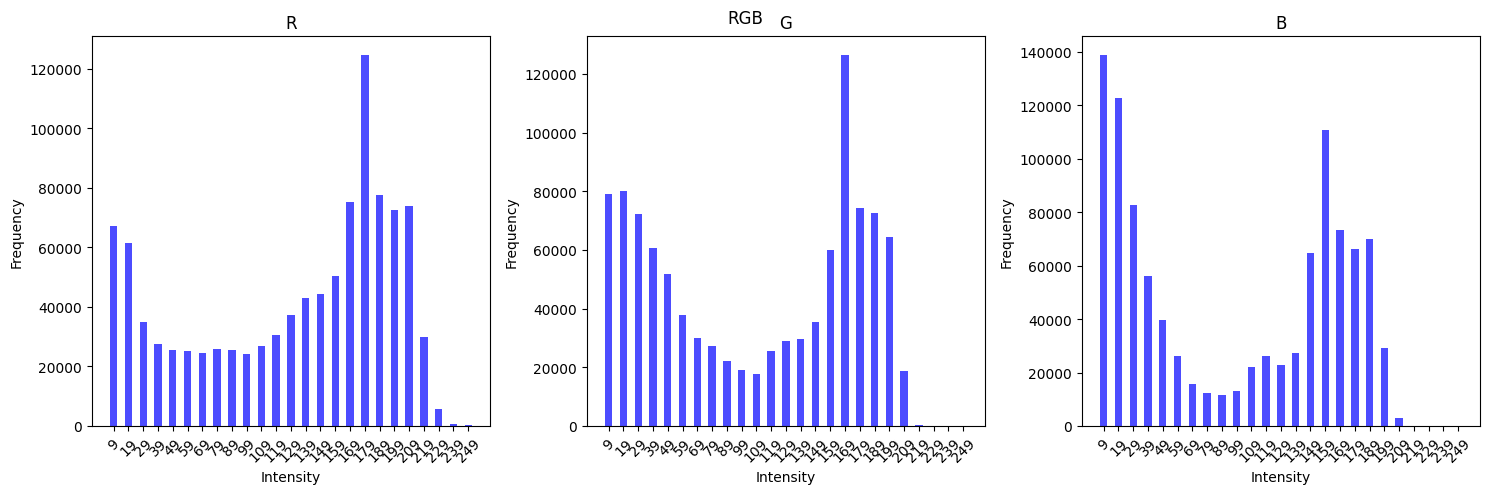

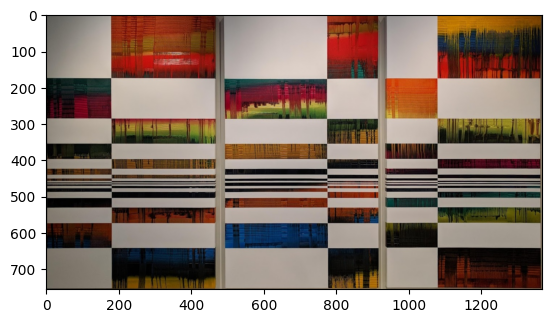

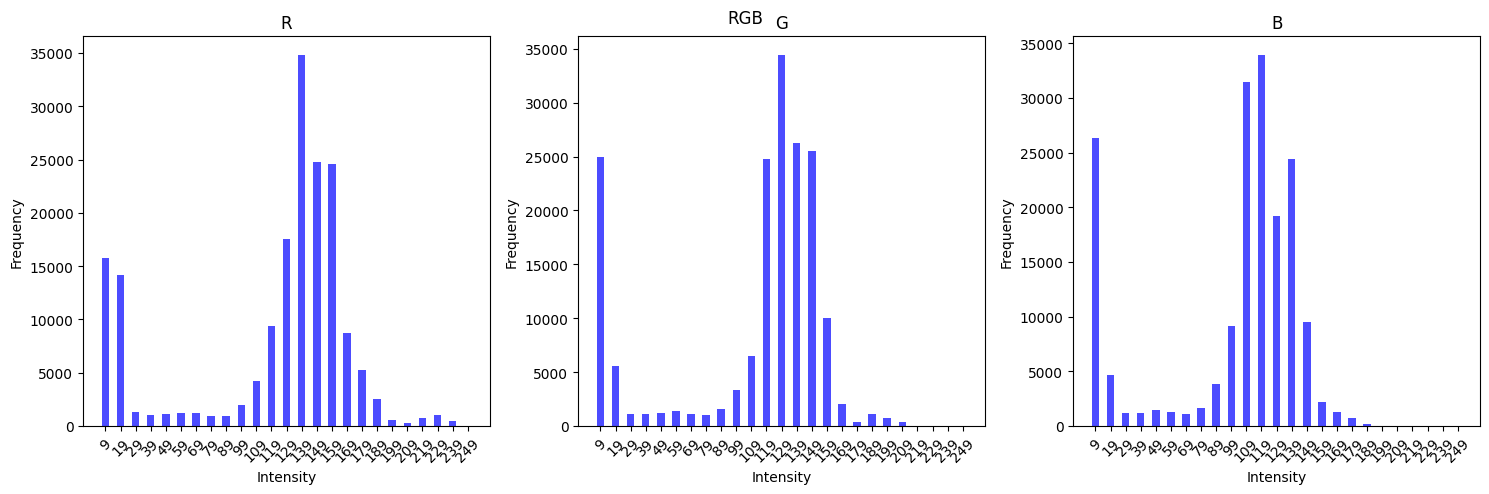

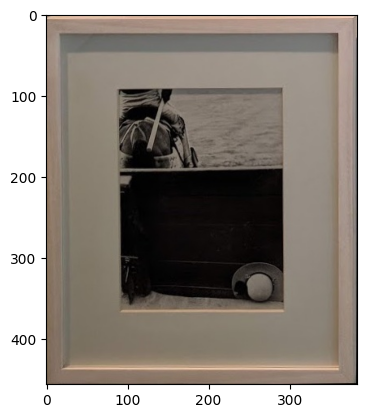

------------------------ Euclidean Distance ------------------------------


[np.float64(219905.58732556115),
 np.float64(237340.4054938813),
 np.float64(262491.0568267041)]

In [21]:
image = Image('./data/BBDD/bbdd_00000.jpg')
image.plot_histograms()
image.show()

image2 = Image('./data/BBDD/bbdd_00002.jpg')
image2.plot_histograms()
image2.show()

print('------------------------ Euclidean Distance ------------------------------')
image.compute_distance(image2, type=DistanceType.euclidean)

In [ ]:
"""
# TASK 2: Similarity measures

Distances:
- Euclidean
- L1
- x^2

Similarity:
- Histogram intersection
- Hellinger kernel

"""
import numpy as np

def euclidean_distance(hist1, hist2):
    return np.linalg.norm(hist1 - hist2)


